# Retrieval Algorithms and Scaling Retrieval

## Motivation

When building a RAG Pipeline for inference, the retrieval component is important for the following reasons:
1. A given algorithm for retrieving subgraph context can have a marked effect on the hallucination rate of the responses in the model
2. A given retrieval algorithm needs to be able to scale to larger graphs of millions of nodes and edges in order to be practical for production.

In this notebook, we will explore how to construct a RAG retrieval algorithm from a given subgraph, and conduct some experiments to evaluate its runtime performance and its effects on hallucination rate.

We want to do so in-line with Pytorch Geometric's in-house framework for remote backends:

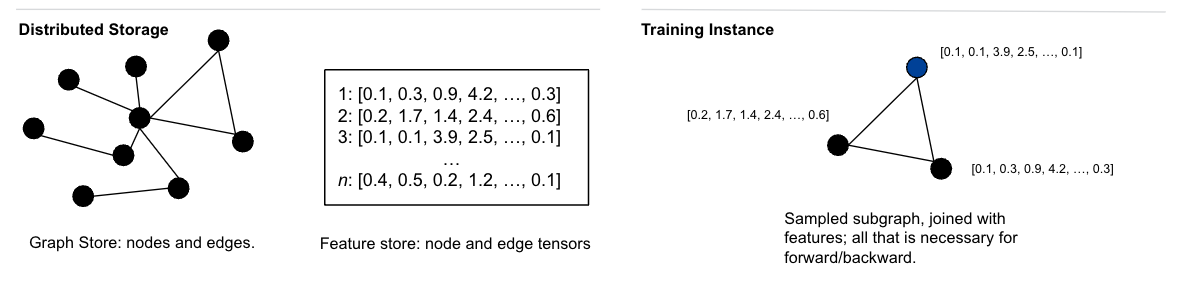

In [26]:
from IPython.display import Image, SVG
Image(filename='../../../docs/source/_figures/remote_2.png')

As seen here, the GraphStore is used to store the neighbor relations between the nodes of the graph, whereas the FeatureStore is used to store the node and edge features in the graph.

Let's start by loading in a knowledge graph dataset for the sake of our experiment:

In [14]:
from torch_geometric.data import LargeGraphIndexer
from torch_geometric.datasets import UpdatedWebQSPDataset
from itertools import chain

In [15]:
# Limiting to 10 questions for the sake of compute, but can be increased if necessary
ds = UpdatedWebQSPDataset(root='demo', limit=10)

Let's set up our set of questions and graph triplets:

In [16]:
questions = ds.raw_dataset['question']
questions

['what is the name of justin bieber brother',
 'what character did natalie portman play in star wars',
 'what country is the grand bahama island in',
 'what kind of money to take to bahamas',
 'what character did john noble play in lord of the rings',
 'who does joakim noah play for',
 'where are the nfl redskins from',
 'where did saki live',
 'who did draco malloy end up marrying',
 'which countries border the us']

In [17]:
ds.raw_dataset[:10]['graph']

[[['P!nk', 'freebase.valuenotation.is_reviewed', 'Gender'],
  ['1Club.FM: Power', 'broadcast.content.artist', 'P!nk'],
  ['Somebody to Love', 'music.recording.contributions', 'm.0rqp4h0'],
  ['Rudolph Valentino',
   'freebase.valuenotation.is_reviewed',
   'Place of birth'],
  ['Ice Cube', 'broadcast.artist.content', '.977 The Hits Channel'],
  ['Colbie Caillat', 'broadcast.artist.content', 'Hot Wired Radio'],
  ['Stephen Melton', 'people.person.nationality', 'United States of America'],
  ['Record producer',
   'music.performance_role.regular_performances',
   'm.012m1vf1'],
  ['Justin Bieber', 'award.award_winner.awards_won', 'm.0yrkc0l'],
  ['1.FM Top 40', 'broadcast.content.artist', 'Geri Halliwell'],
  ['2011 Teen Choice Awards',
   'award.award_ceremony.awards_presented',
   'm.0yrkr34'],
  ['m.012bm2v1', 'celebrities.friendship.friend', 'Miley Cyrus'],
  ['As Long As You Love Me (Ferry Corsten radio)',
   'common.topic.notable_types',
   'Musical Recording'],
  ['Toby Gad', 'mus

In [18]:
all_triplets = chain.from_iterable((row['graph'] for row in ds.raw_dataset))

With these questions and triplets, we want to:
1. Consolidate all the relations in these triplets into a Knowledge Graph
2. Create a FeatureStore that encodes all the nodes and edges in the knowledge graph
3. Create a GraphStore that encodes all the edge indices in the knowledge graph

In [19]:
import torch
from torch_geometric.nn.nlp import SentenceTransformer
from torch_geometric.datasets.updated_web_qsp_dataset import preprocess_triplet

In [20]:
import sys
sys.path.append('..')

In order to create a remote backend, we need to define a FeatureStore and GraphStore locally, as well as a method for initializing its state from triplets:

In [21]:
from profiling_utils import create_remote_backend_from_triplets, RemoteGraphBackendLoader

# We define this GraphStore to sample the neighbors of a node locally.
# Ideally for a real remote backend, this interface would be replaced with an API to a Graph DB, such as Neo4j.
from rag_graph_store import NeighborSamplingRAGGraphStore

# We define this FeatureStore to encode the nodes and edges locally, and perform appoximate KNN when indexing.
# Ideally for a real remote backend, this interface would be replaced with an API to a vector DB, such as Pinecone.
from rag_feature_store import SentenceTransformerFeatureStore

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer(model_name="sentence-transformers/all-roberta-large-v1").to(device)

backend_loader: RemoteGraphBackendLoader = create_remote_backend_from_triplets(
    triplets=all_triplets, # All the triplets to insert into the backend
    node_embedding_model=model, # Embedding model to process triplets with
    node_method_to_call="encode", # This method will encode the nodes/edges with 'model.encode' in this case.
    path="backend", # Save path
    pre_transform=preprocess_triplet, # Preprocessing function to apply to triplets before invoking embedding model.
    node_method_kwargs={"batch_size": 256}, # Keyword arguments to pass to the node_method_to_call.
    graph_db=NeighborSamplingRAGGraphStore, # Graph Store to use
    feature_db=SentenceTransformerFeatureStore # Feature Store to use
    ) 
# This loader saves a copy of the processed data locally to be transformed into a graphstore and featurestore when load() is called.
feature_store, graph_store = backend_loader.load()

Now that we have initialized our remote backends, we can now retrieve from them using a Loader to query the backends, as shown in this diagram:

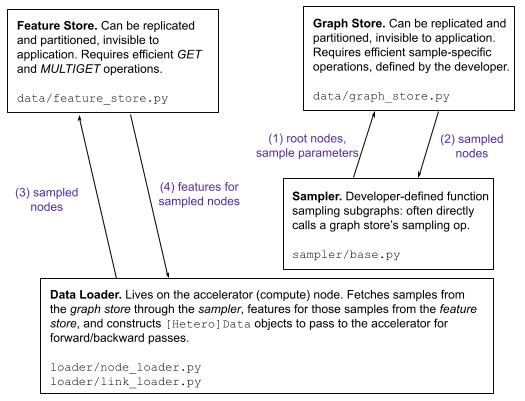

In [23]:
Image(filename='../../../docs/source/_figures/remote_3.png')

In [24]:
from torch_geometric.loader import RAGQueryLoader

In [25]:
query_loader = RAGQueryLoader(
    data=(feature_store, graph_store), # Remote Rag Graph Store and Feature Store
    # Arguments to pass into the seed node/edge retrieval methods for the FeatureStore.
    # In this case, it's k for the KNN on the nodes and edges.
    seed_nodes_kwargs={"k_nodes": 10}, seed_edges_kwargs={"k_edges": 10}, 
    # Arguments to pass into the GraphStore's Neighbor sampling method.
    # In this case, the GraphStore implements a NeighborLoader, so it takes the same arguments.
    sampler_kwargs={"num_neighbors": [40]*3},
    # Arguments to pass into the FeatureStore's feature loading method.
    loader_kwargs={},
    # An optional local transform that can be applied on the returned subgraph.
    local_filter=None,
    )

To make better sense of this loader's arguments, let's take a closer look at the retrieval process for a remote backend:

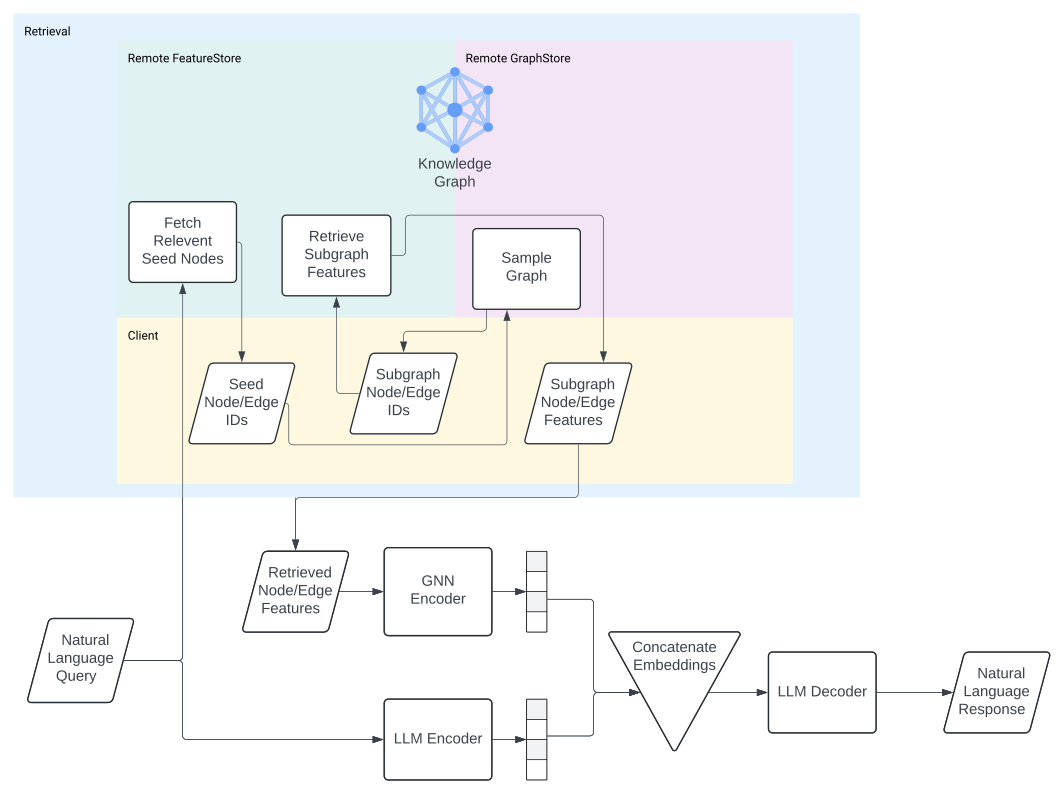

In [29]:
SVG(filename="media/remote_backend.svg")

As we see here, there are 3 important steps to any remote backend procedure for graphs:
1. Retrieve the seed nodes and edges to begin our retrieval process from.
2. Traverse the graph neighborhood of the seed nodes/edges to gather local context.
3. Fetch the features associated with the subgraphs obtained from the traversal.

We can see that our Query Loader construction allows us to specify unique hyperparameters for each unique step in this retrieval.

Now we can submit our queries to the remote backend to retrieve our subgraphs:

In [30]:
import tqdm

In [31]:
sub_graphs = []
for q in tqdm.tqdm(questions):
    sub_graphs.append(query_loader.query(q))

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([11466, 1024])
torch.Size([38145, 1024])


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


In [32]:
sub_graphs[0]

Data(x=[2193, 1024], edge_index=[2, 7295], edge_attr=[7295, 1024], node_idx=[2193], edge_idx=[7295])

These subgraphs are now retrieved using a different retrieval method when compared to the original WebQSP dataset. Can we compare the properties of this method to the original WebQSPDataset's retrieval method?